## 1. Data Cleaning
We'll start by loading the dataset, checking for missing values, handling outliers, and addressing multi-collinearity.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
# Load the dataset
df = pd.read_csv("Fraud.csv")

In [7]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802339 entries, 0 to 4802338
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 403.0+ MB
None


In [8]:
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   step      type    amount     nameOrig  ...  oldbalanceDest  newbalanceDest isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  C1231006815  ...             0.0             0.0     0.0             0.0
1     1   PAYMENT   1864.28  C1666544295  ...             0.0             0.0     0.0             0.0
2     1  TRANSFER    181.00  C1305486145  ...             0.0             0.0     1.0             0.0
3     1  CASH_OUT    181.00   C840083671  ...         21182.0             0.0     1.0             0.0
4     1   PAYMENT  11668.14  C2048537720  ...             0.0             0.0     0.0             0.0

[5 rows x 11 columns]


In [9]:
# Missing Values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [13]:
# Create a mask for rows where 'nameDest' is not NA and starts with 'M'
mask = df['nameDest'].notna() & df['nameDest'].str.startswith('M')

# Set 'oldbalanceDest' and 'newbalanceDest' to 0 for those rows
df.loc[mask, ['oldbalanceDest', 'newbalanceDest']] = 0

In [14]:
print("\nMissing Values After Handling Merchants:")
print(df.isnull().sum())


Missing Values After Handling Merchants:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [15]:
df.dropna(inplace=True)

In [16]:
# Outliers (Using IQR for 'amount' as an example)
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [17]:
df['amount'] = df['amount'].clip(lower_bound, upper_bound)

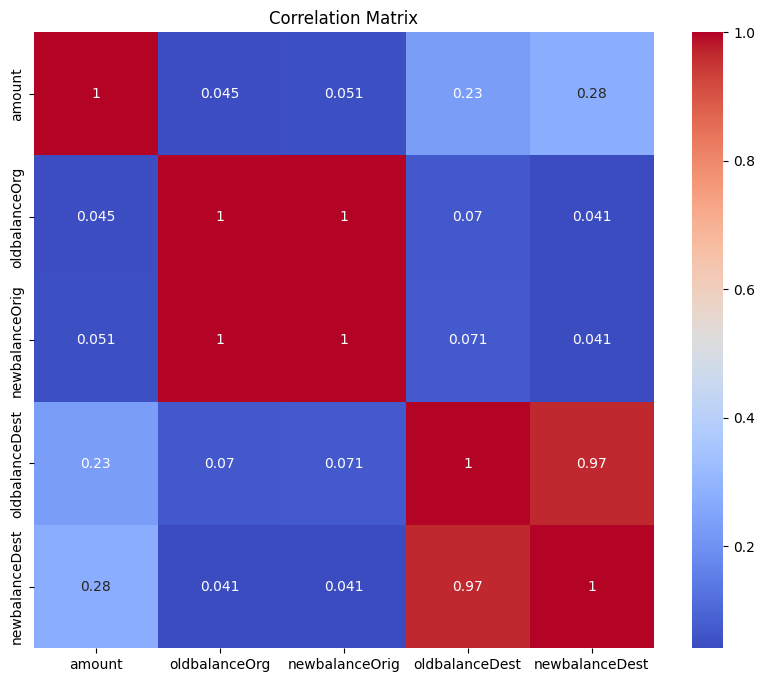

In [18]:
# Multi-collinearity (Check correlation for numerical features)
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [19]:
# Calculate VIF
X_numeric = df[numerical_cols]
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

In [20]:
print("\nVariance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
          Feature         VIF
0          amount    1.318509
1   oldbalanceOrg  644.340741
2  newbalanceOrig  647.652523
3  oldbalanceDest   18.635010
4  newbalanceDest   19.175855


## 2. Fraud Detection Model
We'll use a Random Forest Classifier due to its ability to handle imbalanced data and capture complex feature interactions.

In [21]:
# Feature Engineering
df['balanceDiffOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [22]:
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
            'balanceDiffOrig', 'balanceDiffDest', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
X = df[features]
y = df['isFraud']

In [23]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [24]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [26]:
# Predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

## 3. Variable Selection
We use feature importance from the Random Forest model to select key variables.

In [27]:
# Feature Importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [28]:
print("\nFeature Importance:")
print(feature_importance_df)


Feature Importance:
            Feature  Importance
5   balanceDiffOrig    0.302463
1     oldbalanceOrg    0.174549
2    newbalanceOrig    0.125303
0            amount    0.107809
6   balanceDiffDest    0.075304
10    type_TRANSFER    0.064171
9      type_PAYMENT    0.050921
4    newbalanceDest    0.034812
7     type_CASH_OUT    0.033018
3    oldbalanceDest    0.031424
8        type_DEBIT    0.000226


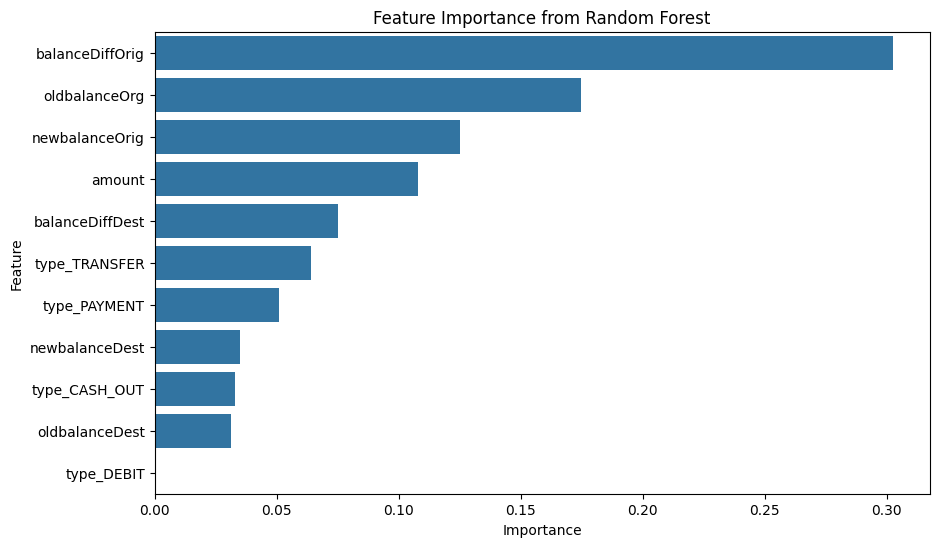

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance from Random Forest")
plt.show()

## 4. Model Performance
We evaluate the model using precision, recall, F1-score, ROC-AUC, and visualizations due to class imbalance.

In [30]:
# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    959697
         1.0       0.96      0.78      0.86       771

    accuracy                           1.00    960468
   macro avg       0.98      0.89      0.93    960468
weighted avg       1.00      1.00      1.00    960468



In [31]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[959670     27]
 [   166    605]]


In [32]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


ROC-AUC Score: 0.9863


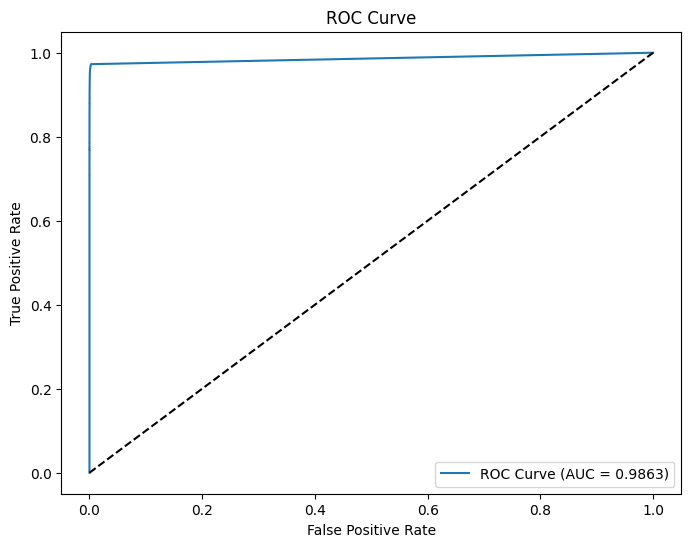

In [33]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

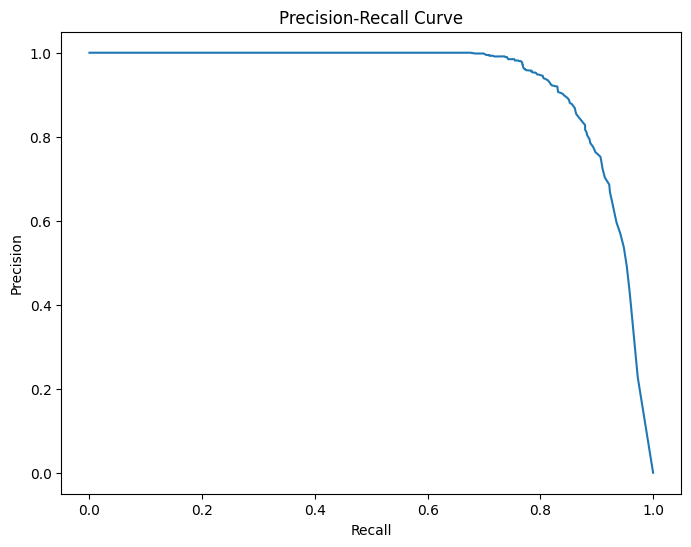

In [34]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

## 5. Key Factors Predicting Fraud
Based on feature importance, we identify the top predictors.

In [35]:
print("\nTop 5 Key Factors Predicting Fraud:")
print(feature_importance_df.head(5))


Top 5 Key Factors Predicting Fraud:
           Feature  Importance
5  balanceDiffOrig    0.302463
1    oldbalanceOrg    0.174549
2   newbalanceOrig    0.125303
0           amount    0.107809
6  balanceDiffDest    0.075304


## 6. Do These Factors Make Sense?
Let’s interpret the key factors:
- **Large `amount`**: Fraudsters often move big sums quickly.
- **Balance Differences**: Sudden changes in balances may indicate unauthorized withdrawals.
- **Transaction Types (e.g., TRANSFER)**: Transfers are common in fraud schemes to move funds out.
These align with typical fraud behavior, making sense in this context.

Fraud often involves large, rapid transactions or specific types like transfers, consistent with the dataset’s simulation.

## 7. Prevention Measures
Based on insights, the company can update its infrastructure:
- **Real-time Monitoring**: Flag transactions with large amounts or specific types (e.g., TRANSFER).
- **Enhanced Authentication**: Require additional verification for high-risk transactions.
- **Customer Education**: Teach customers to recognize and report suspicious activity.

## 8. Determining Effectiveness
To evaluate the implemented measures:
- **Monitor Fraud Rates**: Compare pre- and post-implementation fraud rates.
- **A/B Testing**: Test measures on a subset of transactions and compare outcomes.
- **Feedback Loops**: Retrain the model with new data and track performance metrics over time.